<a href="https://colab.research.google.com/github/Kinnaruo/MachineLearning/blob/main/UTS/Clustering/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples

In [23]:
df = pd.read_csv("UTSClustering.csv", encoding='latin1')

# Drop null dan transaksi negatif/hilang
df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

# Buat fitur Revenue
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

In [24]:
df_cluster = df.groupby("CustomerID").agg({
    "Revenue": "sum",
    "InvoiceNo": "nunique",
    "Quantity": "sum"
}).rename(columns={
    "Revenue": "TotalRevenue",
    "InvoiceNo": "NumTransactions",
    "Quantity": "TotalQuantity"
}).reset_index()

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[["TotalRevenue", "NumTransactions", "TotalQuantity"]])

In [26]:
results_clustering = {}

def evaluate_clustering(name, model, X):
    labels = model.fit_predict(X)

    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chs = calinski_harabasz_score(X, labels)

    results_clustering[name] = {
        "Silhouette": sil,
        "Davies-Bouldin": dbi,
        "Calinski-Harabasz": chs
    }

    print(f"\n📌 {name}")
    print(f"Silhouette Score       : {sil:.3f}")
    print(f"Davies-Bouldin Index   : {dbi:.3f}")
    print(f"Calinski-Harabasz Score: {chs:.3f}")

    return labels

In [27]:
def plot_silhouette(X, labels, name):
    sil_samples = silhouette_samples(X, labels)
    plt.figure(figsize=(6, 3))
    plt.hist(sil_samples, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Silhouette Plot - {name}")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_scatter(X, labels, name):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(6, 4))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(f"Cluster Scatter Plot - {name}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

def plot_dendrogram(X):
    plt.figure(figsize=(10, 4))
    dendro = sch.dendrogram(sch.linkage(X, method='ward'))
    plt.title("Dendrogram - Agglomerative")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()


# KMeans


📌 KMeans
Silhouette Score       : 0.812
Davies-Bouldin Index   : 0.729
Calinski-Harabasz Score: 3711.414


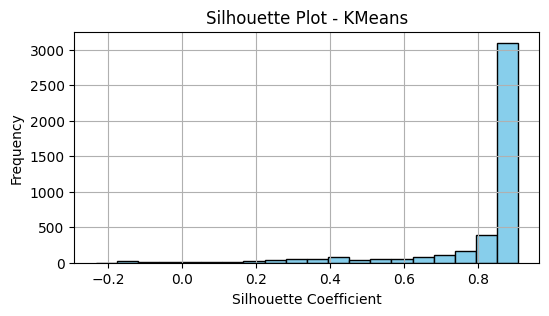

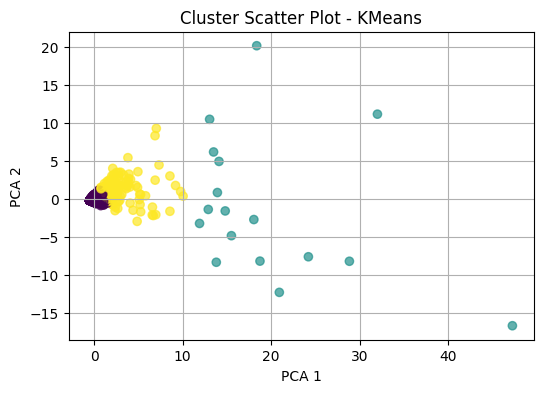

In [28]:
labels_kmeans = evaluate_clustering("KMeans", KMeans(n_clusters=3, random_state=42), X_scaled)
plot_silhouette(X_scaled, labels_kmeans, "KMeans")
plot_scatter(X_scaled, labels_kmeans, "KMeans")

KMeans adalah algoritma clustering yang membagi data ke dalam sejumlah klaster berdasarkan kedekatan titik ke pusat klaster (centroid). Algoritma ini bekerja dengan cara menginisialisasi pusat klaster secara acak lalu melakukan iterasi untuk meminimalkan jarak total antar titik ke centroid masing-masing klaster. KMeans efisien untuk dataset besar dan bekerja baik jika bentuk klasternya bulat dan ukuran tiap klaster relatif seimbang. Namun, KMeans sensitif terhadap inisialisasi awal dan tidak cocok untuk data dengan bentuk klaster yang tidak teratur atau mengandung outlier.

# Agglomerative


📌 Agglomerative
Silhouette Score       : 0.948
Davies-Bouldin Index   : 0.887
Calinski-Harabasz Score: 3263.103


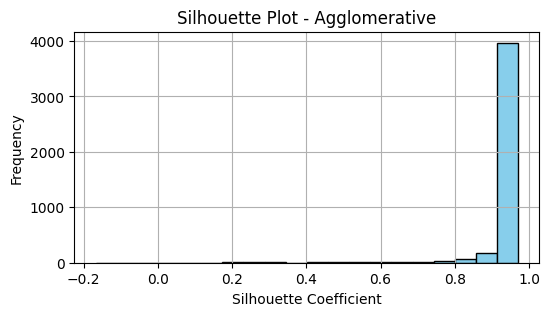

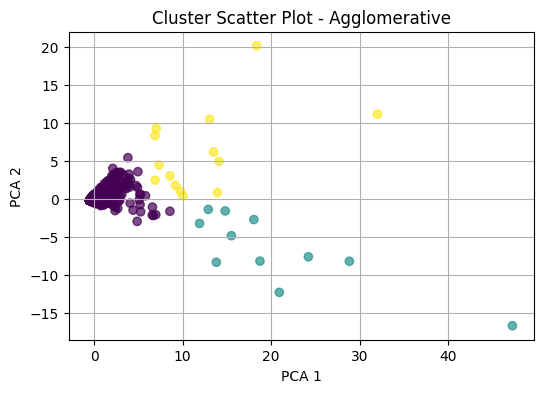

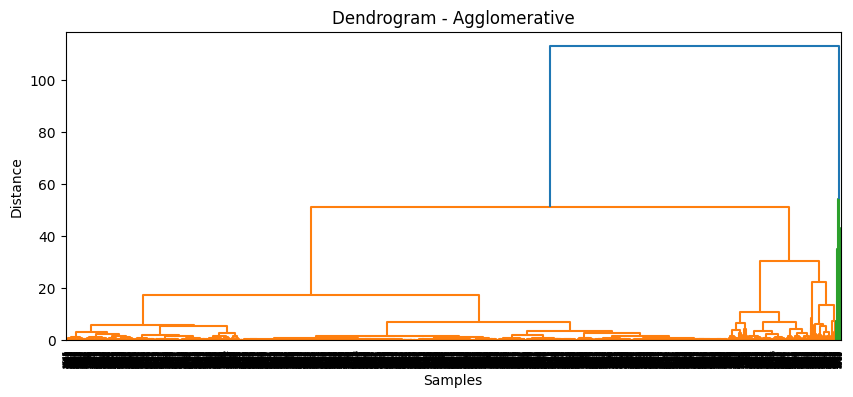

In [29]:
labels_agglo = evaluate_clustering("Agglomerative", AgglomerativeClustering(n_clusters=3), X_scaled)
plot_silhouette(X_scaled, labels_agglo, "Agglomerative")
plot_scatter(X_scaled, labels_agglo, "Agglomerative")
plot_dendrogram(X_scaled)

Agglomerative Clustering merupakan metode hierarchical clustering bottom-up, di mana setiap titik data awalnya dianggap sebagai klaster sendiri, lalu secara bertahap digabungkan berdasarkan kemiripan hingga membentuk satu struktur hierarki (dendrogram). Model ini tidak memerlukan inisialisasi awal dan dapat menangkap bentuk klaster kompleks. Namun, agglomerative clustering cenderung lebih lambat dibanding KMeans dan membutuhkan visualisasi dendrogram untuk menentukan jumlah klaster optimal.

# DBSCAN


📌 DBSCAN
Silhouette Score       : 0.941
Davies-Bouldin Index   : 0.795
Calinski-Harabasz Score: 3350.881


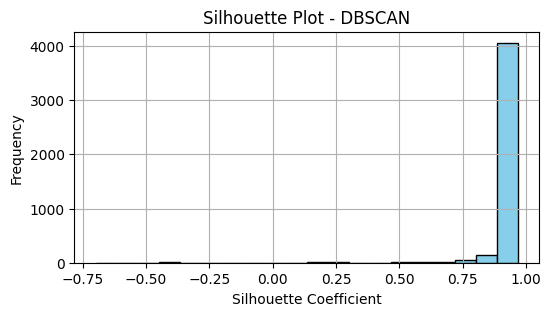

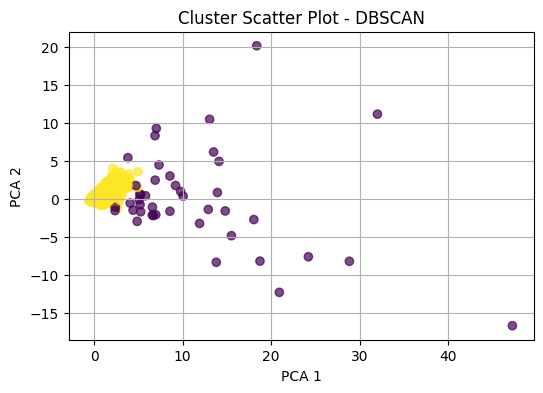

In [30]:
labels_dbscan = evaluate_clustering("DBSCAN", DBSCAN(eps=1.2, min_samples=5), X_scaled)
plot_silhouette(X_scaled, labels_dbscan, "DBSCAN")
plot_scatter(X_scaled, labels_dbscan, "DBSCAN")

DBSCAN mengelompokkan data berdasarkan kerapatan (density) di sekitarnya. Ia dapat menemukan klaster dengan bentuk arbitrer dan mengabaikan noise (outlier) secara otomatis. DBSCAN tidak perlu jumlah klaster ditentukan di awal, tetapi bergantung pada dua parameter utama: epsilon (radius) dan min_samples (jumlah titik minimum dalam radius tersebut). DBSCAN unggul saat menangani data dengan noise atau distribusi tidak beraturan, tapi bisa kesulitan pada dataset dengan variasi kerapatan antar klaster.

# GMM


📌 GaussianMixture
Silhouette Score       : 0.429
Davies-Bouldin Index   : 1.088
Calinski-Harabasz Score: 850.365


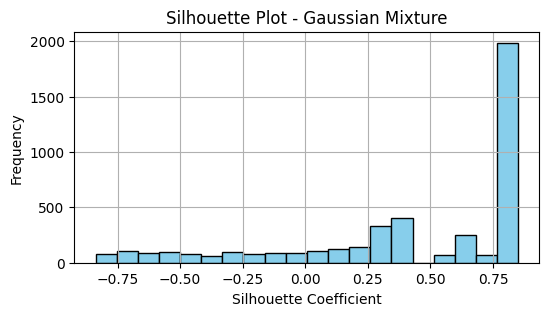

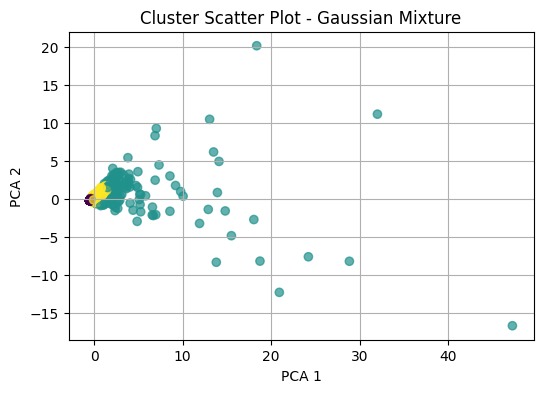

In [31]:
gmm_model = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm_model.fit_predict(X_scaled)
evaluate_clustering("GaussianMixture", gmm_model, X_scaled)
plot_silhouette(X_scaled, labels_gmm, "Gaussian Mixture")
plot_scatter(X_scaled, labels_gmm, "Gaussian Mixture")

GMM adalah metode probabilistik yang mengasumsikan data berasal dari beberapa distribusi Gaussian berbeda. Setiap titik diberi probabilitas keanggotaan dalam masing-masing klaster, tidak seperti KMeans yang memberi label mutlak. GMM fleksibel untuk bentuk klaster yang elips dan dapat menangani overlap antar klaster lebih baik. Namun, GMM membutuhkan asumsi distribusi data dan lebih sensitif terhadap inisialisasi serta jumlah klaster yang ditentukan.

# Spectral


📌 SpectralClustering
Silhouette Score       : 0.147
Davies-Bouldin Index   : 1.062
Calinski-Harabasz Score: 185.676


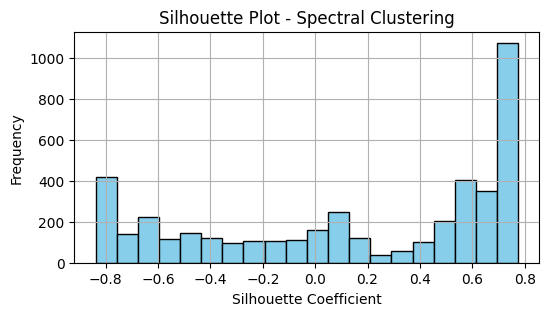

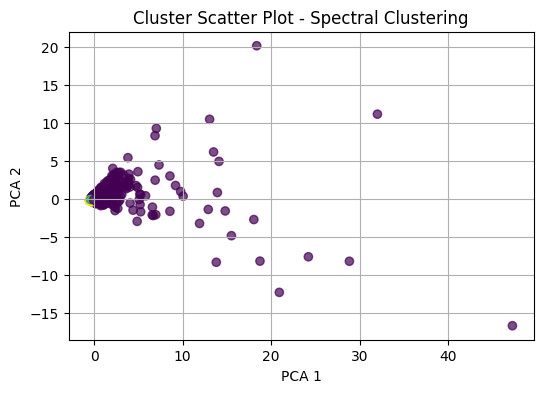

In [32]:
labels_spectral = evaluate_clustering("SpectralClustering", SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42), X_scaled)
plot_silhouette(X_scaled, labels_spectral, "Spectral Clustering")
plot_scatter(X_scaled, labels_spectral, "Spectral Clustering")

Spectral Clustering memanfaatkan spektrum (eigenvalue) dari matriks kedekatan (affinity matrix) antar data untuk memetakan data ke ruang berdimensi lebih rendah, kemudian menerapkan clustering (biasanya KMeans) di ruang tersebut. Algoritma ini efektif dalam menangani klaster dengan bentuk yang tidak linier atau tidak konveks, seperti bentuk lingkaran atau spiral. Kelemahannya adalah sensitif terhadap parameter tetangga terdekat dan skalabilitas buruk untuk dataset sangat besar.

In [33]:
df_cluster_results = pd.DataFrame(results_clustering).T
df_cluster_results = df_cluster_results.sort_values("Silhouette", ascending=False)

print("📊 Ringkasan Evaluasi Model Clustering:")
display(df_cluster_results)

📊 Ringkasan Evaluasi Model Clustering:


,Silhouette,Davies-Bouldin,Calinski-Harabasz
Agglomerative,0.947533,0.887329,3263.103094
DBSCAN,0.941136,0.794601,3350.880641
KMeans,0.812020,0.728553,3711.414321
GaussianMixture,0.428835,1.087786,850.365083
SpectralClustering,0.146960,1.061934,185.675729


Dari kelima model di atas, Agglormerative Clustering memiliki hasil paling stabil. Dengan Silhoutte Score tertinggi dan Clainski-Harabasz tinggi yang artinya cluster jelas terpisah. Davies-Bouldin sedikit lebih tinggi dari Kmeans dan DBSCAN tetapi masih di ambang wajar. Sedangkan model yang kurang bagus adalah Gaussian Mixture dan Spectral Clustering yang sepertinya gagal membentuk cluster atau cluster tidak terbentuk dengan jelas.